# Phase Estimation Algorithm

The aim of this quantum algorithm is to estimate the eigenvalue of a given unitary matrix $U$, given the corresponding eigenstate $|u\rangle$.<br>
Let $U|u\rangle = e^{i2\pi\phi}|u\rangle$ where $\phi\in[0, 1)$. We make our circuit so that it can figure out $2^t\phi$ accurately.

To understand this, let the binary form of $\phi = 0.a_1a_2a_3\ldots a_ta_{t+1}\ldots\implies 2^t\phi = a_1a_2\ldots a_t.a_{t+1}\ldots$.

Now we initialize the required number of qubits in the $|u\rangle$ state, and $t$ qubits in $|++\ldots +\rangle$. Then we use controlled rotations from the work qubits to the eigenstate.
$$CU^x(|0\rangle+1\rangle) = |0\rangle + e^{i2\pi x\phi }|1\rangle$$

Using this fact, using the $k$ th qubit as the control for $U^{2^k}$ on $|u\rangle$ gives us:

$$\bigotimes\limits_{k=t-1}^0 \left(\frac{|0\rangle + e^{i \frac{2\pi 2^k}{2^t} (2^t \phi)}|1\rangle}{\sqrt 2}\right) = \frac{1}{\sqrt{2^t}}\sum\limits_{l=0}^{2^t-1}e^{i2\pi\phi l}|l\rangle$$

This is similar to the state obtained after the QFT, hence we then apply the Inverse QFT on the work qubits. The final step if to measure the $t$ qubits to get out estimate of $2^t\phi$.



In [34]:
from qiskit import QuantumCircuit, assemble, Aer, transpile
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_vector, array_to_latex, plot_bloch_multivector
from math import sqrt, pi
from IPython.display import display, Math
from qiskit.quantum_info import random_statevector
svsim = Aer.get_backend('aer_simulator')

In [35]:
theta = 2 * np.pi * (0.43569)

def inv_QFT(qc, n):
    for i in range(n):
        qc.barrier()
        for j in range(1 + i, 1, -1):
            qc.cp(-2*np.pi/(2**j), (i - (j - 1)), i)
        qc.h(i)
    qc.barrier()

def reverse(qc, n):
    for i in range(0, n//2):
        qc.swap(i, n - 1 - i)

def power_U(theta, power):
    U = QuantumCircuit(1)
    for i in range(power):
        U.p(theta, 0)
    U.name = f"U**{power}"
    c_U = U.control()
    return c_U



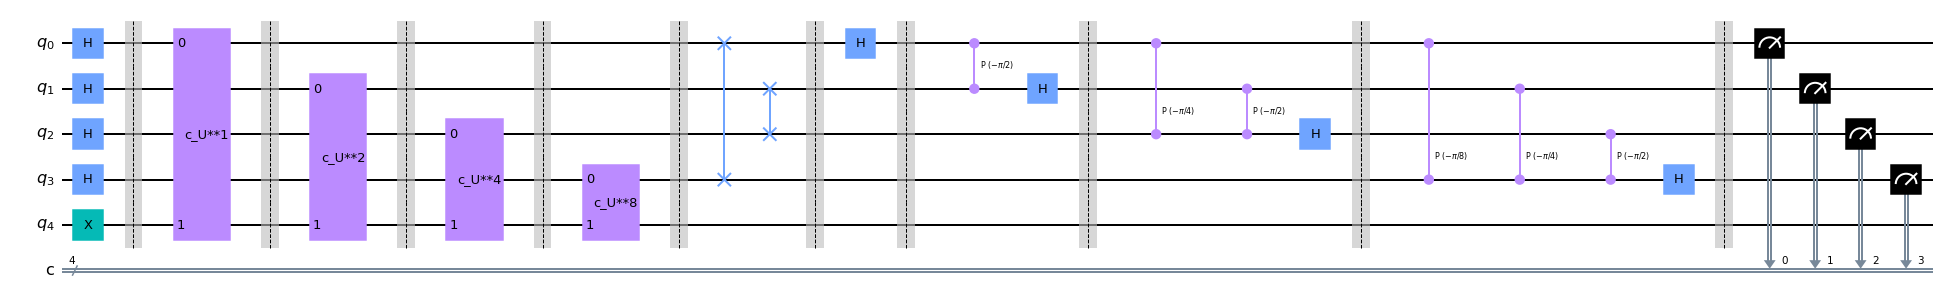

In [36]:
def phase_est(qc, t, theta):
    for i in range(t):
        qc.h(i)
    qc.barrier()
    for i in range(t):
        qc.append(power_U(theta, 2**i), [i, t])
        #for j in range(2**i):
        #    cU(qc, i, t, theta)
        qc.barrier()
n = 4
qc = QuantumCircuit(n+1, n)
qc.x(n)
phase_est(qc, n, theta)
reverse(qc, n)
inv_QFT(qc, n)
qc.measure(range(n), range(n))
qc.draw('mpl', fold=-1)

As can be seen below, our estimate for $16\phi = (0111)_2 = 7\implies \phi = 0.4375$. This is pretty close to the actual value of $0.43569$

Ideally, to estimate $\phi$ correctly upto $n$ decimal digits with probability $1-\epsilon$ we need to have $t = n + p$ gates where $p = \lceil{\log\left(2 + \frac{1}{2\epsilon}\right)}\rceil$

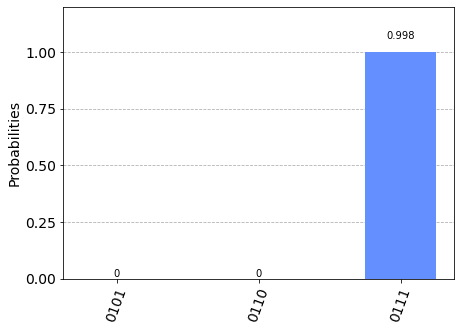

In [37]:
t_qc = transpile(qc, svsim)
qobj = assemble(t_qc)
counts = svsim.run(qobj).result().get_counts()
plot_histogram(counts)